In [12]:
import os
import sys
sys.path.insert(1, '/home/rbbidart/.local-mosaic/lib/python2.7/site-packages')

import numpy as np
import pandas as pd
import random
import glob
from PIL import Image
from keras.models import load_model

In [13]:
def create_heatmap(image_loc, model, height, downsample):
        
    def softmax(x):
        e_x = np.exp(x - np.max(x))
        return e_x / e_x.sum()
#     def softmax(x):
#         """Compute softmax values for each sets of scores in x."""
#         return np.exp(x) / np.sum(np.exp(x), axis=0)

    image = np.array(Image.open(image_loc))
    image_shape = image.shape
    image = image/255.0 # During training the images were normalized
    height = int(height)

    out_shape = np.ceil(np.array(image.shape)/float(downsample)).astype(int)
    out_shape[2] = 4 # there are 4 classes

    delta=int((height)/2)
    print image.shape
    image = np.lib.pad(image, ((delta, delta-1), (delta, delta-1), (0,0)), 'constant', constant_values=(0, 0))
    print image.shape
    out_shape[2] = 4
    
    image = np.expand_dims(image, axis=0)
    out_image = model.predict(image, batch_size=1, verbose=0)
    print out_image.shape
    
    #out_image = out_image[delta:-1*delta, delta:-1*delta]
    out_image = np.reshape(out_image, out_shape)
    print 'out_image.shape before softmax', out_image.shape
    print out_image[32,32,:]


    out_image = np.apply_along_axis(softmax, 2, out_image)
    print 'out_image.shape after softmax', out_image.shape
    print out_image[32,32,:]

    return out_image

In [17]:
import sys
sys.path.insert(0, '/Users/rb/Google_Drive/Waterloo/projects/cancer_hist/src')
from functions import*
from heat_models import*
import matplotlib.pyplot as plt
% matplotlib inline

# Look at 134_Region_1

image_loc = '/Users/rb/Documents/waterloo/projects/cancer_hist/full_slides/train/134_Region_1_crop.tif'
xml_loc = '/Users/rb/Documents/waterloo/projects/cancer_hist/full_slides/train/134_Region_1_key.xml'
image = np.asarray(Image.open(image_loc))

height = 64
# model_loc = load_model('/Users/rb/Google_Drive/Waterloo/projects/cancer_hist/output_old_2/size64_fc_class/conv6_.109-0.90.hdf5')
model_loc = '/Users/rb/Google_Drive/Waterloo/projects/cancer_hist/output/model_conv_fc2/conv_fc2_64_.151-0.88.hdf5'
model = load_model(model_loc)
last = model.layers[-2].output
model = Model(model.input, last)

print(model.summary())
heat = create_heatmap(image_loc=image_loc, model=model, height=height, downsample=1)

true_pts = get_points_xml(xml_loc)
points = non_max_supression(heatmap=heat, radius=10, cutoff = .95, stride = 1)
print('image.shape', image.shape)
print('len(true_pts)', len(true_pts))
print('len(points)', len(points))

def softmax(x):
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum()

image_tmp = np.expand_dims(image, axis=0)
image_tmp = image_tmp/255.0
single_preds = model.predict(image_tmp[:, 0:65, 0:64, :], batch_size=1, verbose=0)
out_image = np.reshape(single_preds, (2,1,4))

print single_preds

image_prob_sum = np.sum(single_preds, 2)
print image_prob_sum

print 'single_preds', single_preds
print softmax(single_preds)
# stride=4
# points[:,0] = points[:,0]*stride
# points[:,1] = points[:,1]*stride

f = plt.figure(figsize=(15,15))
sp = f.add_subplot(3, 6//3, 1)
sp.axis('Off')
sp.set_title('Prob of none', fontsize=20)
plt.tight_layout()
plt.imshow(heat[:,:,0])

sp = f.add_subplot(3, 6//3, 2)
sp.axis('Off')
sp.set_title('Lymphocyte', fontsize=20)
plt.tight_layout()
plt.imshow(heat[:,:,1])

sp = f.add_subplot(3, 6//3, 3)
sp.axis('Off')
sp.set_title('Normal Epithelial', fontsize=20)
plt.tight_layout()
plt.imshow(heat[:,:,2])

sp = f.add_subplot(3, 6//3, 4)
sp.axis('Off')
sp.set_title('Malignant Epithelial', fontsize=20)
plt.tight_layout()
plt.imshow(heat[:,:,3])

#f = plt.figure(figsize=(20,20))
sp = f.add_subplot(3, 6//3, 5)
sp.axis('Off')
sp.set_title('Raw Image - Estimated points', fontsize=20)
image2 = np.array(image)
for row in range(len(points)):
    if points[row, 2] == 1:
        color = [0, 0, 255]
    elif points[row, 2] == 2:
        color = [0, 255, 0]  
    elif points[row, 2] == 3:
        color = [255, 0, 0]
    image2[int(points[row, 0])-2:int(points[row, 0])+2, int(points[row, 1])-2:int(points[row, 1])+2, :] = color
plt.tight_layout()
plt.imshow(image2)

#f = plt.figure(figsize=(20,20))
sp = f.add_subplot(3, 6//3, 6)
sp.axis('Off')
sp.set_title('Raw Image - Actual points', fontsize=20)
image2 = np.array(image)
for row in range(len(true_pts)):
    if true_pts[row, 2] == 1:
        color = [0, 0, 255]
    elif true_pts[row, 2] == 2:
        color = [0, 255, 0]  
    elif true_pts[row, 2] == 3:
        color = [255, 0, 0]
    image2[int(true_pts[row, 0])-2:int(true_pts[row, 0])+2, int(true_pts[row, 1])-2:int(true_pts[row, 1])+2, :] = color
plt.tight_layout()
plt.imshow(image2)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1_input (InputLayer)  (None, None, None, 3)     0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, None, None, 32)    896       
_________________________________________________________________
batch_normalization_1 (Batch (None, None, None, 32)    128       
_________________________________________________________________
activation_1 (Activation)    (None, None, None, 32)    0         
_________________________________________________________________
dropout_1 (Dropout)          (None, None, None, 32)    0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, None, None, 32)    9248      
_________________________________________________________________
batch_normalization_2 (Batch (None, None, None, 32)    128       
__________

ValueError: 'axis' entry is out of bounds

In [ ]:
def create_heatmap(image_loc, model, height, downsample):
    def softmax(x):
        e_x = np.exp(x - np.max(x))
        return e_x / e_x.sum()

    image = np.array(Image.open(image_loc))
    image_shape = image.shape
    image = image/255.0 # During training the images were normalized
    height = int(height)

    out_shape = np.ceil(np.array(image.shape)/float(downsample)).astype(int)
    out_shape[2] = 4 # there are 4 classes

    delta=int((height)/2)
    image = np.lib.pad(image, ((delta, delta-1), (delta, delta-1), (0,0)), 'constant', constant_values=(0, 0))
    image = np.expand_dims(image, axis=0)
    out_image = model.predict(image, batch_size=1, verbose=0)
    #out_image = out_image[delta:-1*delta, delta:-1*delta]
    out_image = np.reshape(out_image, out_shape)
    return out_image

out_shape [440 641   4]
heat.shape (440, 641, 4)
('image.shape', (440, 641, 3))
('len(true_pts)', 18)
('len(points)', 63)


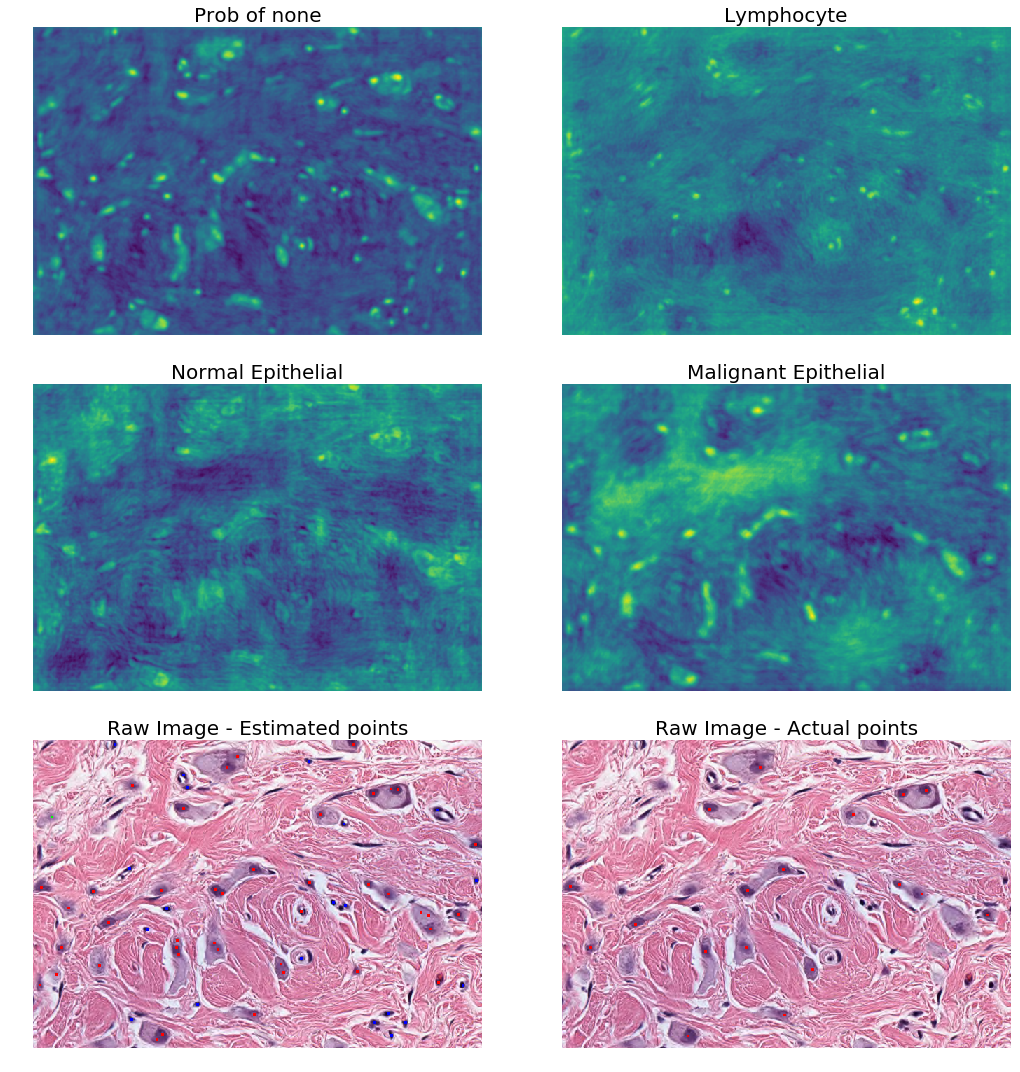

In [28]:
import sys
sys.path.insert(0, '/Users/rb/Google_Drive/Waterloo/projects/cancer_hist/src')
from functions import*
from heat_models import*
import matplotlib.pyplot as plt
% matplotlib inline

# Look at 134_Region_1

image_loc = '/Users/rb/Documents/waterloo/projects/cancer_hist/full_slides/train/134_Region_1_crop.tif'
xml_loc = '/Users/rb/Documents/waterloo/projects/cancer_hist/full_slides/train/134_Region_1_key.xml'
image = np.asarray(Image.open(image_loc))

height = 64
# model_loc = load_model('/Users/rb/Google_Drive/Waterloo/projects/cancer_hist/output_old_2/size64_fc_class/conv6_.109-0.90.hdf5')
model_loc = '/Users/rb/Google_Drive/Waterloo/projects/cancer_hist/output/model_conv_fc2/conv_fc2_64_.151-0.88.hdf5'


def create_heatmap(image_loc, model_loc, height, downsample):
    def softmax(x):
        e_x = np.exp(x - np.max(x))
        return e_x / e_x.sum()
    
    image = np.array(Image.open(image_loc))
    image_shape = image.shape
    image = image/255.0 # During training the images were normalized
    height = int(height)
    
    model = load_model(model_loc)
    last = model.layers[-2].output
    model = Model(model.input, last)

    out_shape = np.ceil(np.array(image.shape)/float(downsample)).astype(int)
    out_shape[2] = 4 # there are 4 classes

    delta=int((height)/2)
    image = np.lib.pad(image, ((delta, delta-1), (delta, delta-1), (0,0)), 'constant', constant_values=(0, 0))
    image = np.expand_dims(image, axis=0)
    heat = model.predict(image, batch_size=1, verbose=0)
    heat = np.reshape(heat, out_shape)
    return heat


heat = create_heatmap(image_loc=image_loc, model_loc=model_loc, height=height, downsample=1)

true_pts = get_points_xml(xml_loc)
points = non_max_supression(heatmap=heat, radius=10, cutoff = .95, stride = 1)
print('image.shape', image.shape)
print('len(true_pts)', len(true_pts))
print('len(points)', len(points))x

f = plt.figure(figsize=(15,15))
sp = f.add_subplot(3, 6//3, 1)
sp.axis('Off')
sp.set_title('Prob of none', fontsize=20)
plt.tight_layout()
plt.imshow(heat[:,:,0])

sp = f.add_subplot(3, 6//3, 2)
sp.axis('Off')
sp.set_title('Lymphocyte', fontsize=20)
plt.tight_layout()
plt.imshow(heat[:,:,1])

sp = f.add_subplot(3, 6//3, 3)
sp.axis('Off')
sp.set_title('Normal Epithelial', fontsize=20)
plt.tight_layout()
plt.imshow(heat[:,:,2])

sp = f.add_subplot(3, 6//3, 4)
sp.axis('Off')
sp.set_title('Malignant Epithelial', fontsize=20)
plt.tight_layout()
plt.imshow(heat[:,:,3])

#f = plt.figure(figsize=(20,20))
sp = f.add_subplot(3, 6//3, 5)
sp.axis('Off')
sp.set_title('Raw Image - Estimated points', fontsize=20)
image2 = np.array(image)
for row in range(len(points)):
    if points[row, 2] == 1:
        color = [0, 0, 255]
    elif points[row, 2] == 2:
        color = [0, 255, 0]  
    elif points[row, 2] == 3:
        color = [255, 0, 0]
    image2[int(points[row, 0])-2:int(points[row, 0])+2, int(points[row, 1])-2:int(points[row, 1])+2, :] = color
plt.tight_layout()
plt.imshow(image2)

#f = plt.figure(figsize=(20,20))
sp = f.add_subplot(3, 6//3, 6)
sp.axis('Off')
sp.set_title('Raw Image - Actual points', fontsize=20)
image2 = np.array(image)
for row in range(len(true_pts)):
    if true_pts[row, 2] == 1:
        color = [0, 0, 255]
    elif true_pts[row, 2] == 2:
        color = [0, 255, 0]  
    elif true_pts[row, 2] == 3:
        color = [255, 0, 0]
    image2[int(true_pts[row, 0])-2:int(true_pts[row, 0])+2, int(true_pts[row, 1])-2:int(true_pts[row, 1])+2, :] = color
plt.tight_layout()
plt.imshow(image2)